In [1]:
import pandas as pd
import numpy as np 
import re
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(19, 7), 'axes.titlesize':16, 'axes.labelsize':14, 'xtick.labelsize':12, 
            'ytick.labelsize':12,'axes.titlepad': 30, # 'font.family': 'Roboto' 
           })

In [3]:
df_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-se-vlasov/interim project/olist_orders_dataset.csv', \
                        parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                                       'order_delivered_customer_date', 'order_estimated_delivery_date'])

-  order_id —  уникальный идентификатор заказа (номер чека)
-  customer_id —  позаказный идентификатор пользователя
-  order_status —  статус заказа
-  order_purchase_timestamp —  время создания заказа
-  order_approved_at —  время подтверждения оплаты заказа
-  order_delivered_carrier_date —  время передачи заказа в логистическую службу
-  order_delivered_customer_date —  время доставки заказа
-  order_estimated_delivery_date —  обещанная дата доставки

In [4]:
df_customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-se-vlasov/interim project/olist_customers_dataset.csv')

-  customer_id — позаказный идентификатор пользователя
-  customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
-  customer_zip_code_prefix —  почтовый индекс пользователя
-  customer_city —  город доставки пользователя
-  customer_state —  штат доставки пользователя

In [5]:
df_order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-se-vlasov/interim project/olist_order_items_dataset.csv', \
                             parse_dates=['shipping_limit_date'])

-  order_id —  уникальный идентификатор заказа (номер чека)
-  order_item_id —  идентификатор товара внутри одного заказа
-  product_id —  ид товара (аналог штрихкода)
-  seller_id — ид производителя товара
-  shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
-  price —  цена за единицу товара
-  freight_value —  вес товара

In [6]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
df_orders.shape

(99441, 8)

In [8]:
# минимальная дата создания заказа
df_orders['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [9]:
# максимальная дата создания заказа
df_orders['order_purchase_timestamp'].max()

Timestamp('2018-10-17 17:30:18')

In [10]:
df_orders.isnull().any()

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                 True
order_delivered_carrier_date      True
order_delivered_customer_date     True
order_estimated_delivery_date    False
dtype: bool

<b>Видим наличие пустых данных(null) в колонках:</b><br>
-  order_approved_at
-  order_delivered_carrier_date
-  order_delivered_customer_date<br>

Это говорит о том, что не все заказы были оплачены и по итогу доставлены

In [11]:
df_orders \
    .groupby('order_status', as_index=False) \
    .agg({'order_id' : 'count'}) 

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [12]:
#Посмотрим на датафрейм с покупателями
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [13]:
df_customers.shape

(99441, 5)

In [14]:
#кол-во уникальных пользователей
df_customers['customer_unique_id'].nunique()

96096

In [15]:
#количетсво позаказных идентификатор пользователей = количеству уникальных заказов
df_customers['customer_id'].nunique() == df_orders['order_id'].nunique()

True

In [16]:
df_customers.isnull().any()

customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
dtype: bool

In [17]:
#посмотрим на датафрейм с товарными позициями, входящими в заказы
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [18]:
df_order_items['order_id'].nunique() == df_orders['order_id'].nunique()

False

Количество уникальных идентификаторов заказа (номер чека) <b>НЕ РАВНО</b> количеству уникальных заказов<br>
-  Найдем количество отсутствующих чеков(по какой-то причине):

In [19]:
#Отсутствуют 775 чеков
df_orders['order_id'].nunique() - df_order_items['order_id'].nunique()

775

In [20]:
df_order_items.isnull().any()

order_id               False
order_item_id          False
product_id             False
seller_id              False
shipping_limit_date    False
price                  False
freight_value          False
dtype: bool

In [21]:
df_order_items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [22]:
df_order_items['order_item_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [23]:
df_order_items \
    .groupby('order_id', as_index=False) \
    .agg({'product_id' : 'count'}) \
    .rename(columns={'product_id' : 'cnt_products'}) \
    .sort_values(by='cnt_products', ascending=False)

,order_id,cnt_products
50137,8272b63d03f5f79c56e9e4120aec44ef,21
10459,1b15974a0141d54e36626dca3fdc731a,20
65715,ab14fdcfbe524636d65ee38360e22ce8,20
60941,9ef13efd6949e4573a18964dd1bbe7f5,15
25583,428a2f660dc84138d969ccd69a0ab6d5,15
...,...,...
34640,5a0911d70c1f85d3bed0df1bf693a6dd,1
34639,5a082b558a3798d3e36d93bfa8ca1eae,1
34637,5a07264682e0b8fbb3f166edbbffc6e8,1
34636,5a071192a28951b76774e5a760c8c9b7,1


In [24]:
#объединяем датафреймы customers и orders 
df_customers_orders = df_customers.merge(df_orders, on='customer_id')

In [25]:
df_customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


### 1.Сколько у нас пользователей, которые совершили покупку только один раз?

<b>За покупку будем считать:</b><br>
-  Заказ был отгружен со склада (т.е имеется в наличии и был полностью собран)
-  Заказ был доставлен (время доставки не нулевое)
-  Заказ не был отменен по различным причинам в момент доставки 

<b>Найдем заказы которые были доставлены(имеют не нулевое время доставки), но по каким-то причинам отменены:</b>

In [26]:
df_customers_orders.query('order_delivered_customer_date != "NaT" & order_status == "canceled"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
27088,6c57e6119369185e575b36712766b0ef,59a7bb642795ddc85534fbd5f7360334,20091,rio de janeiro,RJ,770d331c84e5b214bd9dc70a10b829d0,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
50569,1bccb206de9f0f25adc6871a1bcf77b2,6a04c8339c44b23e189446216a494569,32071,contagem,MG,1950d777989f6a877539f53795b4c3c3,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
57499,bf609b5741f71697f65ce3852c5d2623,f9af3bfab584769f34c314b222d34263,20091,rio de janeiro,RJ,8beb59392e21af5eb9547ae1a9938d06,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
59705,70fc57eeae292675927697fe03ad3ff5,b8b8726af116a5cfb35b0315ecef9172,22770,rio de janeiro,RJ,65d1e226dfaeb8cdc42f665422522d14,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
76291,de4caa97afa80c8eeac2ff4c8da5b72e,d93a22bb52bb2f41a7267b8a02370781,88058,florianopolis,SC,2c45c33d2f9cb8ff8b1c86cc28c11c30,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08
77039,5cdec0bb8cbdf53ffc8fdc212cd247c6,2f96790fba243100730c8d1185dd2f25,5846,sao paulo,SP,dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30


In [27]:
#Посчитаем количество уникальных id пользователей, совершивших ровно одну покупку
df_one_buy = df_customers_orders.query("order_status == ['shipped', 'delivered'] & order_delivered_customer_date != 'NaT'") \
                .groupby("customer_unique_id", as_index=False) \
                .agg({"customer_zip_code_prefix": "count"}) \
                .rename(columns={'customer_zip_code_prefix' : 'cnt_orders'}) \
                .query("cnt_orders == 1").count()
df_one_buy

customer_unique_id    90549
cnt_orders            90549
dtype: int64

<b>Убедимся, что найденные нами доставленные, но отмененные заказы, не попали в итоговый датасет:</b>

In [28]:
df_customers_orders.query("order_status == ['shipped', 'delivered'] & order_delivered_customer_date != 'NaT'")['order_id'] \
    .isin(df_customers_orders.query('order_delivered_customer_date != "NaT" & order_status == "canceled"')['order_id']).sum()

0

### Ответ: 90549 пользователей, которые совершили покупку только один раз

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Найдем заказы с отсутствующей датой доставки и сгруппируем по статусу

In [29]:
df_customers_orders \
    .query("order_delivered_customer_date == 'NaT'") \
    .groupby('order_status', as_index=False) \
    .agg({'customer_id' : 'count'})


,order_status,customer_id
0,approved,2
1,canceled,619
2,created,5
3,delivered,8
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


<b>Рассмотрим следующие статусы заказов:</b><br>
-  delivered (доставка заказа была осуществлена после назначенной даты)
-  canceled (заказ был отменен)
-  unavailable (отсутствуют наименования на складе)

In [30]:
df_customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [31]:
df_customers_orders_cp = df_customers_orders.copy()

In [32]:
df_customers_orders_cp['month'] = df_customers_orders_cp['order_estimated_delivery_date'].dt.strftime('%Y-%m')

In [33]:
df_delivery_time_exceeded = df_customers_orders_cp.query('order_delivered_customer_date.dt.date > order_estimated_delivery_date')
df_delivery_time_exceeded.shape

(6535, 13)

<b>В назначенную дату НЕ доставлено: 6535 заказов</b><br>
Вникнем глубже. Данную причину можно разбить на составляющие:<br>
-  максимальная дата доставки продавцом для передачи заказа партнеру по логистике - превышена
-  логистическая служба просрочила доставку


In [34]:
#объединим датафрейм orders и orders_items
df_orders_and_orders_items = df_orders.merge(df_order_items, on='order_id', how='left')

In [35]:
df_orders_and_orders_items['month'] = df_orders_and_orders_items['order_estimated_delivery_date'].dt.strftime('%Y-%m')

In [36]:
df_orders_and_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,2018-08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,2018-09
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,2017-12
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,2018-02


In [37]:
df_shipping_limit_date_exceeded = df_orders_and_orders_items.query('order_delivered_carrier_date > shipping_limit_date')
df_shipping_limit_date_exceeded.shape

(10423, 15)

<b>Теперь проверим какие заказы были задержаны при передаче логистической службе и впоследствие были доставлены клиенту с задержкой:</b> 

In [38]:
df_delivery_time_exceeded_sh = df_delivery_time_exceeded[df_delivery_time_exceeded['order_id'] \
                                    .isin(df_shipping_limit_date_exceeded['order_id'])]
df_delivery_time_exceeded_sh.shape

(1814, 13)

In [39]:
df_delivery_time_exceeded = df_delivery_time_exceeded.copy()
df_delivery_time_exceeded['reason'] = np.where((df_delivery_time_exceeded['order_id'].isin(df_delivery_time_exceeded_sh['order_id'])) \
                                               ,'shipp_time_exceeded','logistic_delay')

In [40]:
df_delivery_time_exceeded.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,reason
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-06,shipp_time_exceeded
18,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,2017-05,logistic_delay
59,a905baa530258422594f1b05615bd225,c80da60feddb7cf8325bd104032e314a,60140,fortaleza,CE,4f0695330f3816ef294bf1f4b18f4f2e,delivered,2018-03-29 21:28:04,2018-03-29 21:35:20,2018-04-12 23:36:29,2018-05-08 16:52:07,2018-04-23,2018-04,shipp_time_exceeded
89,6bed27564bd99d78d09c1fac13da56fd,463093247faa080167d77f2e6d1b297d,13321,salto,SP,0e5d9583490deb1e011b1c8e7da13398,delivered,2018-03-22 12:07:30,2018-03-22 12:15:45,2018-03-27 22:12:24,2018-05-09 19:48:38,2018-04-11,2018-04,logistic_delay
96,23e96758fd640560e9b1fbcda90abfc4,9e1f719fe5b17b9c51905fee6d6385c1,5565,sao paulo,SP,fb9a9bc9654c16364f348fb2309b1214,delivered,2018-04-02 08:54:48,2018-04-02 09:09:07,2018-04-11 22:08:39,2018-04-20 21:42:29,2018-04-19,2018-04,shipp_time_exceeded
98,5f8b4882b5a4ec7bf6d2107e6cd0cf29,694cb45ff29b603ac2acd51016770097,24120,niteroi,RJ,1d748fa1652f04b064b6cf65739b04dc,delivered,2017-12-05 12:56:13,2017-12-06 02:35:38,2017-12-12 19:51:56,2018-01-09 12:20:41,2017-12-29,2017-12,shipp_time_exceeded
99,ad6891a1937cb8723a2c08ba1ae59873,9dbb05f5577e862337b93feb8f358839,65058,sao luis,MA,38289de96763d9d81470f67583f4b2f0,delivered,2018-08-22 11:49:11,2018-08-23 02:44:21,2018-08-23 12:39:00,2018-08-29 19:48:37,2018-08-27,2018-08,logistic_delay
103,126cf4e9fd189d2d64bc9b112fd6a5e8,90d479448b39ad9586d05da64cfb695b,62016,sobral,CE,af3fae91bafed6357991c4a3be0125d4,delivered,2017-03-28 11:16:48,2017-03-28 11:30:17,2017-03-30 11:22:43,2017-05-17 15:41:52,2017-05-03,2017-05,logistic_delay
122,e32daa14dfa90eff675034dc7d462cf3,52e57dd9218d99ea21b26f00c9151761,28909,cabo frio,RJ,08b74b3a8bd41e7de2ac99b200eec62d,delivered,2018-05-09 13:48:11,2018-05-09 14:15:01,2018-05-10 13:29:00,2018-06-09 16:03:26,2018-05-28,2018-05,logistic_delay
131,53b6d45cb9684a4b93e0ba2030222456,5d348bbc0f1a5cc45c3e4b93b8c9f802,24431,sao goncalo,RJ,4550a99f6056026fc76c5030f0f45fe6,delivered,2017-06-24 13:10:07,2017-06-24 13:23:15,2017-06-26 14:52:14,2017-08-16 15:36:05,2017-07-18,2017-07,logistic_delay


In [41]:
df_delivery_time_exceeded['reason'].value_counts()

logistic_delay         4721
shipp_time_exceeded    1814
Name: reason, dtype: int64

Делаем вывод, что:
-  1814 заказов не были доставлены вовремя из-за превышения максимальной даты доставки продавцом для передачи заказа партнеру по логистике
- 4721 заказов не были доставлены вовремя из-за проблем логистической службы 

In [42]:
#теперь поработаем с заказами статуса canceled и unavailable
df_canceled = df_customers_orders.query('order_delivered_customer_date == "NaT" and order_status=="canceled"').copy()
df_canceled['month'] = df_canceled['order_estimated_delivery_date'].dt.strftime('%Y-%m')
df_canceled['reason'] = 'canceled'

In [43]:
df_unavailable = df_orders_and_orders_items.query('order_delivered_customer_date == "NaT" \
                and order_status=="unavailable"  \
                and shipping_limit_date=="NaT"').copy()
df_unavailable['month'] = df_unavailable['order_estimated_delivery_date'].dt.strftime('%Y-%m')
df_unavailable['reason'] = 'unavailable'

Теперь видим, что:
-  619 заказов не были доставлены по причине отмены заказа 
-  603 заказа не было доставлено про причине недоступности товара<br>
<b>Далее объединим все в итоговую таблицу, сгруппируем и сагрегируем данные и получим среднее колличество заказов в разбивке по причинам:</b>

In [44]:
df_canceled_unavailable = pd.concat([df_canceled,df_unavailable])

In [45]:
df_total = pd.concat([df_delivery_time_exceeded,df_canceled_unavailable])

In [46]:
df_total.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,reason,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151.0,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-06,shipp_time_exceeded,NaN,NaN,NaN,NaT,NaN,NaN
18,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416.0,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,2017-05,logistic_delay,NaN,NaN,NaN,NaT,NaN,NaN
59,a905baa530258422594f1b05615bd225,c80da60feddb7cf8325bd104032e314a,60140.0,fortaleza,CE,4f0695330f3816ef294bf1f4b18f4f2e,delivered,2018-03-29 21:28:04,2018-03-29 21:35:20,2018-04-12 23:36:29,2018-05-08 16:52:07,2018-04-23,2018-04,shipp_time_exceeded,NaN,NaN,NaN,NaT,NaN,NaN
89,6bed27564bd99d78d09c1fac13da56fd,463093247faa080167d77f2e6d1b297d,13321.0,salto,SP,0e5d9583490deb1e011b1c8e7da13398,delivered,2018-03-22 12:07:30,2018-03-22 12:15:45,2018-03-27 22:12:24,2018-05-09 19:48:38,2018-04-11,2018-04,logistic_delay,NaN,NaN,NaN,NaT,NaN,NaN
96,23e96758fd640560e9b1fbcda90abfc4,9e1f719fe5b17b9c51905fee6d6385c1,5565.0,sao paulo,SP,fb9a9bc9654c16364f348fb2309b1214,delivered,2018-04-02 08:54:48,2018-04-02 09:09:07,2018-04-11 22:08:39,2018-04-20 21:42:29,2018-04-19,2018-04,shipp_time_exceeded,NaN,NaN,NaN,NaT,NaN,NaN


### Ответ:

In [47]:
df_total \
    .groupby(['reason', 'month'], as_index=False) \
    .agg({'customer_id' : 'count'}) \
    .groupby('reason', as_index=False) \
    .agg({'customer_id' : 'mean'})

,reason,customer_id
0,canceled,23.807692
1,logistic_delay,248.473684
2,shipp_time_exceeded,86.380952
3,unavailable,30.150000


### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [48]:
#создаем копию датафрема, для того, чтобы избежать ошибок при создании нового столбца
df_orders_and_orders_items_cp = df_orders_and_orders_items.copy()

In [49]:
#создаем новую колонку, где для каждого заказа будет отображен день создания заказа
df_orders_and_orders_items_cp['weekday']=df_orders_and_orders_items_cp['order_purchase_timestamp'].dt.strftime('%A')

In [50]:
df_orders_and_orders_items_cp.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017-10,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,2018-08,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,2018-09,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,2017-12,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,2018-02,Tuesday


<b>В задании №1 мы уже определили, что будем считать за покупку:</b></br>
-  Заказ был отгружен со склада (т.е имеется в наличии и был полностью собран)
-  Заказ был доставлен (время доставки не нулевое)
-  Заказ не был отменен по различным причинам в момент доставки 


In [51]:
df_items = df_orders_and_orders_items_cp.query("order_status == ['shipped', 'delivered'] & order_delivered_customer_date != 'NaT'")

In [52]:
df_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017-10,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,2018-08,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,2018-09,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,2017-12,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,2018-02,Tuesday


-  Далее считаем количество заказов по id и дням недели:

In [53]:
# подсчет кол-ва заказов по товару и дням недели
df_items_total = df_items \
    .groupby(['product_id', 'weekday'], as_index=False).agg({'order_id': 'count'}) \
    .rename(columns={'order_id':'orders_cnt'}) \
    .sort_values(by='orders_cnt', ascending=False)
df_items_total

,product_id,weekday,orders_cnt
15595,422879e10f46682990de24d770e7f83d,Wednesday,93
35749,99a4788cb24856965c36a24e339b6058,Monday,91
40180,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40181,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
40176,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,83
...,...,...,...
23489,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
23491,641444946fe3a839d726c32804cd1aff,Tuesday,1
23492,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1
23493,64187b994e1b15e6a59a6f72688fbea8,Friday,1


In [54]:
#Проверка на дубликаты
df_items_total.duplicated().any()

False

-  В датафрейме df_items_total мы получили количество заказов всех product_id по всем дням недели т.е на один product_id может приходится несколько строк с weekday и разным order_cnt. Наша задача, оставить только те дни, где для отдельно взятого product_id, order_cnt - максимальный

In [55]:
df_items_total.query('product_id == "422879e10f46682990de24d770e7f83d"' )

,product_id,weekday,orders_cnt
15595,422879e10f46682990de24d770e7f83d,Wednesday,93
15593,422879e10f46682990de24d770e7f83d,Thursday,79
15589,422879e10f46682990de24d770e7f83d,Friday,77
15594,422879e10f46682990de24d770e7f83d,Tuesday,67
15590,422879e10f46682990de24d770e7f83d,Monday,64
15591,422879e10f46682990de24d770e7f83d,Saturday,57
15592,422879e10f46682990de24d770e7f83d,Sunday,47


In [56]:
df_items_total['product_id'].nunique()

32214

In [57]:
df_max_items = df_items_total \
    .groupby('product_id', as_index=False) \
    .agg({'orders_cnt' : 'max'}) \
    .sort_values(by='orders_cnt', ascending=False)
df_max_items

,product_id,orders_cnt
8428,422879e10f46682990de24d770e7f83d,93
19289,99a4788cb24856965c36a24e339b6058,91
21615,aca2eb7d00ea1a7b8ebd4e68314663af,89
10615,53b36df67ebb7c41585e8d54d6772e08,76
6925,368c6c730842d78016ad823897a372db,67
...,...,...
12468,62a183c5f3895060ba1a8f1415694908,1
12467,62a068fa5b6d1cb8015c754504a10bfa,1
12464,629beb8e7317703dcc5f35b5463fd20e,1
12461,62962adb9db1eeb96d0dd8fd2eb87875,1


<b>Полученный датафрейм df_max_items содержит максимальное число покупок для каждого product_id. Однако, у каждого product_id может быть несколько дней с максимальным числом orders_cnt. Выполним соединение с первоначальным датафреймом и проверим гипотезу.</b>

In [58]:
df_result = df_items_total.merge(df_max_items, how='inner', on=['product_id', 'orders_cnt'])

In [59]:
df_result['product_id'].nunique()

32214

In [60]:
df_result.head()

,product_id,weekday,orders_cnt
0,422879e10f46682990de24d770e7f83d,Wednesday,93
1,99a4788cb24856965c36a24e339b6058,Monday,91
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
3,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
4,389d119b48cf3043d311335e499d9c6b,Thursday,67


In [61]:
#проверка гипотезы
df_result \
    .groupby('product_id', as_index=False) \
    .agg({'weekday' : 'count'}) \
    .sort_values(by='weekday', ascending=False)

,product_id,weekday
26856,d4fe034cde911805af12724d73fde7e0,7
19613,9c31382f02ac001fe1a33a466471d98c,7
29059,e707c577789af56087a82650995ed3c8,6
22180,b0c657fb8995510c4729dcb9739226c8,6
2865,162e010af9fe224d35fd8496a273fb02,6
...,...,...
11990,5eb7102793807195374fcd13de07eb62,1
11989,5eb564652db742ff8f28759cd8d2652a,1
11988,5eb0dafaaed0ede2f7957dbbef6a071c,1
11987,5eaec7fd1d19f063638a519d473cb200,1


In [62]:
#проверка гипотезы
df_result.query('product_id == "d4fe034cde911805af12724d73fde7e0"')

,product_id,weekday,orders_cnt
17228,d4fe034cde911805af12724d73fde7e0,Wednesday,1
17229,d4fe034cde911805af12724d73fde7e0,Tuesday,1
17230,d4fe034cde911805af12724d73fde7e0,Thursday,1
17231,d4fe034cde911805af12724d73fde7e0,Sunday,1
17232,d4fe034cde911805af12724d73fde7e0,Saturday,1
17233,d4fe034cde911805af12724d73fde7e0,Monday,1
17234,d4fe034cde911805af12724d73fde7e0,Friday,1


<b>Видим, что некоторые товары действительно могут иметь больше одного дня с максимальным числом orders_cnt</b>

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

<b>В задании №1 мы уже определили, что будем считать за покупку:</b></br>
-  Заказ был отгружен со склада (т.е имеется в наличии и был полностью собран)
-  Заказ был доставлен (время доставки не нулевое)
-  Заказ не был отменен по различным причинам в момент доставки 

In [63]:
#Сделаем копию датафрейма с покупками
df_items = df_items.copy()

In [64]:
#объединим все три имеющихся датафрейма в один
df_items = df_items.merge(df_customers, how='inner', on='customer_id')

In [65]:
#Создаем колонку с явным указанием месяца создания заказа
df_items['delivered_month'] = df_items['order_purchase_timestamp'].dt.strftime('%B')

In [66]:
#Создаем колонку с указанием количества недель в месяце, используя dt.daysinmonth
df_items['week_in_month'] = df_items['order_purchase_timestamp'].dt.daysinmonth / 7

In [67]:
#Создадим дополнительную колонку с месяц-год для теста 
df_items['month_year'] = df_items['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [68]:
df_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,freight_value,month,weekday,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivered_month,week_in_month,month_year
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,8.72,2017-10,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,October,4.428571,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,22.76,2018-08,Tuesday,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,July,4.428571,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,19.22,2018-09,Wednesday,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,August,4.428571,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,27.20,2017-12,Saturday,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,November,4.285714,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,8.72,2018-02,Tuesday,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,February,4.000000,2018-02


<b>Далее сгруппируем данные по:</b></br>

-  customer_unique_id
-  order_id
-  delivered_month
-  week_in_month</br>

Чтобы учесть тот факт, что предоставлены данные за несколько лет и покупки могут быть совершены в один и тот же месяц, но в разные годы.</br>
Затем аггрегируем и считаем кол-во покупок:
    

In [69]:
df_month_pur = df_items \
    .groupby(['customer_unique_id', 'order_id', 'delivered_month', 'week_in_month', 'month_year'], as_index=False) \
    .agg({'product_id':'count'})  \
    .rename(columns={'product_id':'purchase_cnt'})
df_month_pur.head()

,customer_unique_id,order_id,delivered_month,week_in_month,month_year,purchase_cnt
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,May,4.428571,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,May,4.428571,2018-05,1
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,March,4.428571,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,October,4.428571,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,November,4.285714,2017-11,1


In [70]:
#проверим гипотезу о одинаковых месяцах 
df_month_pur \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'delivered_month' : 'count'}) \
    .sort_values(by='delivered_month', ascending=False)

,customer_unique_id,delivered_month
51426,8d50f5eadf50201ccdcedfb9e2ac8455,15
22774,3e43e6105506432c953e165fb2acf44c,9
36701,6469f99c1f9dfae7733b25662e7f1782,7
73916,ca77025e7201e3b30c44b472ff346268,7
10058,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
31561,565af81202a1fb8a9ffe282935381142,1
31560,56583a02df6f603c331a575f4f63ec6b,1
31559,565811ed44e539a14bc391cf57373ed1,1
31558,5657f9f721c16800a66c21081d46b18d,1


In [71]:
#Подтвержаем гипотезу
df_month_pur.query('customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"') \
    .sort_values(by='month_year')

,customer_unique_id,order_id,delivered_month,week_in_month,month_year,purchase_cnt
53134,8d50f5eadf50201ccdcedfb9e2ac8455,369634708db140c5d2c4e365882c443a,June,4.285714,2017-06,1
53135,8d50f5eadf50201ccdcedfb9e2ac8455,4f62d593acae92cea3c5662c76122478,July,4.428571,2017-07,1
53142,8d50f5eadf50201ccdcedfb9e2ac8455,bf92c69b7cc70f7fc2c37de43e366173,July,4.428571,2017-07,1
53136,8d50f5eadf50201ccdcedfb9e2ac8455,519203404f6116d406a970763ee75799,August,4.428571,2017-08,1
53146,8d50f5eadf50201ccdcedfb9e2ac8455,e3071b7624445af6e4f3a1b23718667d,September,4.285714,2017-09,1
53139,8d50f5eadf50201ccdcedfb9e2ac8455,89d9b111d2b990deb5f5f9769f92800b,October,4.428571,2017-10,1
53144,8d50f5eadf50201ccdcedfb9e2ac8455,cd4b336a02aacabd0ef22f6db711f95e,October,4.428571,2017-10,1
53141,8d50f5eadf50201ccdcedfb9e2ac8455,b850a16d8faf65a74c51287ef34379ce,November,4.285714,2017-11,1
53133,8d50f5eadf50201ccdcedfb9e2ac8455,23427a6bd9f8fd1b51f1b1e5cc186ab8,May,4.428571,2018-05,1
53137,8d50f5eadf50201ccdcedfb9e2ac8455,6bdf325f0966e3056651285c0aed5aad,May,4.428571,2018-05,1


-  Далее разделим количество покупок в месяц на количество недель в месяце, чтобы получить количество сделаных покупок в неделю

In [72]:
df_month_pur['week_purchase'] = df_month_pur['purchase_cnt'] / df_month_pur['week_in_month']

In [73]:
df_month_pur.head()

,customer_unique_id,order_id,delivered_month,week_in_month,month_year,purchase_cnt,week_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,May,4.428571,2018-05,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,May,4.428571,2018-05,1,0.225806
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,March,4.428571,2017-03,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,October,4.428571,2017-10,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,November,4.285714,2017-11,1,0.233333


<b>Теперь сгруппируем данные по:</b></br>

-  customer_unique_id
-  delivered_month</br>

И посчитаем среднее</br>

А так же, для более подробного рассмотрения, отдельно сгруппируем по: month_year


In [74]:
#Итоговая таблица
df_itog = df_month_pur \
    .groupby(['customer_unique_id', 'delivered_month'], as_index=False) \
    .agg({'week_purchase' : 'mean'})
df_itog.head()

,customer_unique_id,delivered_month,week_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,May,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,0.225806
2,0000f46a3911fa3c0805444483337064,March,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,0.233333


In [75]:
#Дополнительный пример с разбивкой по месяцам И годам для customer_unique_id с наибольшим количеством покупок 
df_month_pur \
    .groupby(['customer_unique_id', 'month_year'], as_index=False) \
    .agg({'week_purchase' : 'mean'}) \
    .query('customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"') 

,customer_unique_id,month_year,week_purchase
52418,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06,0.233333
52419,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07,0.225806
52420,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08,0.225806
52421,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09,0.233333
52422,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10,0.225806
52423,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11,0.233333
52424,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05,0.225806
52425,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07,0.225806
52426,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08,0.225806


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [76]:
#копируем датафрейм с покупками и явным указанием "месяц-год", когда был сделан заказ (из прошлого задания)
df_items = df_items.copy()

In [77]:
df_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,freight_value,month,weekday,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivered_month,week_in_month,month_year
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,8.72,2017-10,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,October,4.428571,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,22.76,2018-08,Tuesday,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,July,4.428571,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,19.22,2018-09,Wednesday,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,August,4.428571,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,27.20,2017-12,Saturday,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,November,4.285714,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,8.72,2018-02,Tuesday,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,February,4.000000,2018-02


In [78]:
df_month_orders = df_items \
    .groupby('month_year', as_index=False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns={'customer_unique_id' : 'cnt_orders'}) \
    .sort_values(by='month_year')

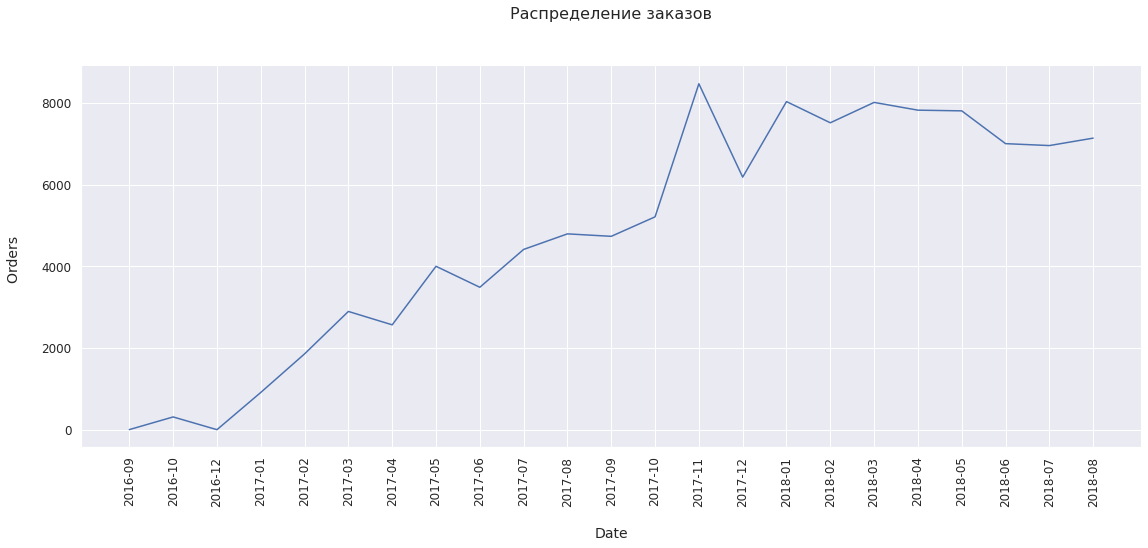

In [79]:
ax = sns.lineplot(x='month_year', y ='cnt_orders', data=df_month_orders)
ax.set_title('Распределение заказов\n') #добавили заголовок 
ax.set_ylabel('Orders \n')             #добавили описание оси y
ax.set_xlabel('\nDate')                        #Описание оси х
plt.xticks(np.arange(len(df_month_orders)), df_month_orders['month_year'], rotation=90)
sns.despine()   #убираем лишние аутпуты перед графиком

In [80]:
first_buy_users = df_items.groupby('customer_unique_id', as_index=False) \
                                .agg({'order_delivered_customer_date': 'min'}) \
                                .rename(columns={'order_delivered_customer_date':'first_orders_period'})
first_buy_users['first_orders_period'] = first_buy_users['first_orders_period'].dt.strftime('%Y-%m')
first_buy_users.head(3)

,customer_unique_id,first_orders_period
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-04


Полученную колонку first_orders_period присоединим к датафрейму df_items, где находятся наши данные по покупкам и т.д

In [81]:
period_by_user = df_items \
    .merge(first_buy_users, on='customer_unique_id')
period_by_user.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,month,weekday,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivered_month,week_in_month,month_year,first_orders_period
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,2017-10,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,October,4.428571,2017-10,2017-09
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,1.0,9abb00920aae319ef9eba674b7d2e6ff,...,2017-09,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,September,4.285714,2017-09,2017-09
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,2018-08,Tuesday,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,July,4.428571,2018-07,2018-08
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,2018-09,Wednesday,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,August,4.428571,2018-08,2018-08
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,2017-12,Saturday,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,November,4.285714,2017-11,2017-12


Далее будем работать с тремя стобцами:
-  customer_unique_id - уникальный идентификатор пользователя 
-  month_year - "месяц-год", когда был сделан заказ
-  first_orders_period - дата первой покупки

In [82]:
df_test = period_by_user[['customer_unique_id', 'month_year', 'first_orders_period']]
df_test.head()

,customer_unique_id,month_year,first_orders_period
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09
2,af07308b275d755c9edb36a90c618231,2018-07,2018-08
3,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
4,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-12


Сгруппируем данные по first_orders_period (дата первой покупки) и посчитаем сколько человек совершили свою первую покупку в том или ином месяце. Далее сджойним полученный столбец customer_cnt с таблицей df_test.

In [83]:
df_period_users = df_test \
    .groupby('first_orders_period', as_index=False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns={'customer_unique_id' : 'customer_cnt'})
df_cohorts = df_test.merge(df_period_users, how='left', on='first_orders_period')
df_cohorts.head()

,customer_unique_id,month_year,first_orders_period,customer_cnt
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,4596
1,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09,4596
2,af07308b275d755c9edb36a90c618231,2018-07,2018-08,9143
3,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08,9143
4,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-12,8298


In [84]:
# проведем группировку данных: верхняя группировка по first_orders_period (когорты), следом по orders_period (периоды когорт).
# Считаем кол-во пользователей из когорты, совершивших покупку

cohorts=df_cohorts.groupby(['first_orders_period', 'month_year'])  \
                .agg({'customer_unique_id':'nunique', 'customer_cnt':'max'})  \
                .rename(columns={'customer_unique_id': 'users_of_cohorts'})

# будем рассматривать когорты только за 2017 год плюс 3 месяца 2018, чтобы отследить CRR на третий месяц
cohorts=cohorts.query('"2016-12" < first_orders_period < "2018-01" and month_year < "2018-04"')
cohorts.head(10)

users_of_cohorts  customer_cnt
first_orders_period month_year                                
2017-01             2017-01                  263           346
                    2017-03                    1           346
                    2017-05                    1           346
                    2017-06                    1           346
                    2017-07                    2           346
                    2017-11                    3           346
                    2018-01                    3           346
                    2018-02                    1           346
2017-02             2017-01                  431          1618
                    2017-02                  896          1618

In [85]:
#уберем индексы
cohorts = cohorts.reset_index()

<b>Формула Customer Retention Rate:</b></br>

$$
CRR = [(CE - CN)/ CS] * 100
$$</br>
Где: 
-  CE - Количество клиентов на конец периода (customer_cnt)
-  CN - Новые пользователи
-  CS - количество клиентов в когорте (users_of_cohorts)

In [86]:
cohorts['CRR'] = round(cohorts.users_of_cohorts/cohorts.customer_cnt * 100, 2)
cohorts.head()

,first_orders_period,month_year,users_of_cohorts,customer_cnt,CRR
0,2017-01,2017-01,263,346,76.01
1,2017-01,2017-03,1,346,0.29
2,2017-01,2017-05,1,346,0.29
3,2017-01,2017-06,1,346,0.29
4,2017-01,2017-07,2,346,0.58


Напишем анонимную функцию для определения порядкового значения периода когорты т.е потенциально месяца, когда мы ждем повторения покупки

In [87]:
cohorts['cohort_period'] = cohorts['month_year'].apply(lambda x: int(x.split('-')[1]) if x.split('-')[0] == '2017' else int(x.split('-')[1]) + 12)
cohorts.head()

,first_orders_period,month_year,users_of_cohorts,customer_cnt,CRR,cohort_period
0,2017-01,2017-01,263,346,76.01,1
1,2017-01,2017-03,1,346,0.29,3
2,2017-01,2017-05,1,346,0.29,5
3,2017-01,2017-06,1,346,0.29,6
4,2017-01,2017-07,2,346,0.58,7


In [88]:
#возвращаем индексы и добавляем периоды когорты 
cohorts.set_index(['first_orders_period', 'cohort_period'], inplace=True)
df_itog_table = cohorts['CRR'].unstack(1)

In [89]:
df_itog_table

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
first_orders_period,,,,,,,,,,,,,,,
2017-01,76.01,NaN,0.29,NaN,0.29,0.29,0.58,NaN,NaN,NaN,0.87,NaN,0.87,0.29,NaN
2017-02,26.64,55.38,0.25,0.19,0.25,0.19,0.19,0.19,0.06,0.06,0.06,0.12,0.31,0.19,0.12
2017-03,0.64,25.38,57.19,0.39,0.21,0.28,0.18,0.18,0.25,0.21,0.28,0.11,0.21,0.07,0.18
2017-04,0.19,0.66,39.41,44.42,0.37,0.28,0.19,0.23,0.05,0.28,0.19,0.19,0.23,0.19,0.09
2017-05,0.02,0.05,0.85,29.48,53.75,0.32,0.32,0.16,0.27,0.30,0.25,0.16,0.27,0.21,0.21
2017-06,NaN,0.03,0.05,0.37,29.05,53.55,0.40,0.42,0.37,0.21,0.42,0.21,0.08,0.19,0.13
2017-07,NaN,NaN,0.02,NaN,0.20,24.90,58.23,0.20,0.25,0.25,0.32,0.17,0.37,0.07,0.20
2017-08,NaN,0.02,NaN,NaN,NaN,0.26,27.60,55.39,0.46,0.26,0.22,0.30,0.40,0.14,0.18
2017-09,NaN,0.02,0.24,0.15,0.07,0.13,0.50,27.72,54.77,0.46,0.35,0.22,0.37,0.26,0.20


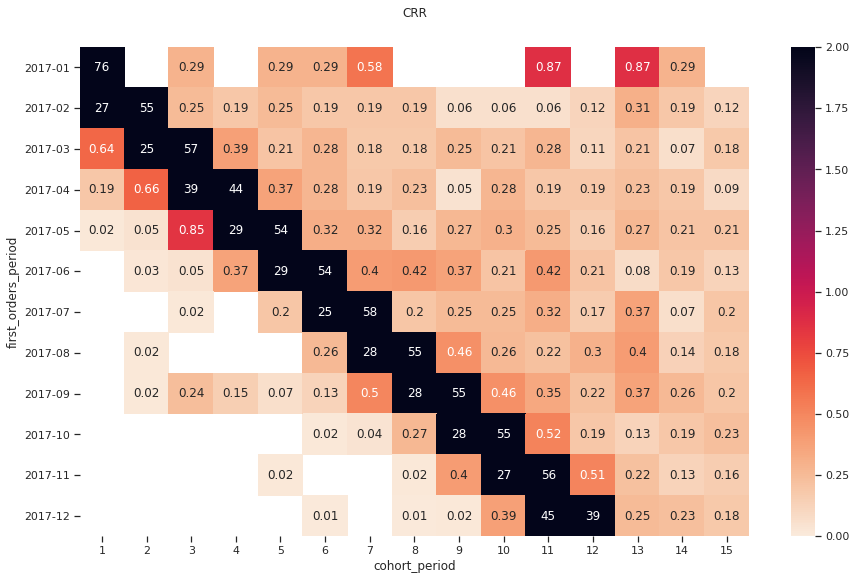

In [90]:
# построим тепловую карту CRR
sns.set(style='ticks')
cmap = sns.cm.rocket_r
plt.figure(figsize=(15, 9))
plt.xlabel('Cohorts')
plt.title('CRR')
sns.heatmap(df_itog_table, cmap=cmap,annot=True, vmin=0, vmax=2, center= 1)

In [91]:
max_crr = cohorts.copy()
max_crr.reset_index(inplace=True)

sp1, sp2=[], []
for i, row in max_crr.iterrows():
    coh=int(row['first_orders_period'].split('-')[1])
    if row['cohort_period']==(coh+3):
        sp1.append(row['first_orders_period'])
        sp2.append(row['CRR'])

<b>Ответ:</b>

In [92]:
df=pd.DataFrame({'coh': sp1, 'CRR': sp2})
df.loc[df['CRR'].idxmax()]

coh    2017-06
CRR       0.37
Name: 4, dtype: object

### 6.Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

In [93]:
df_items = df_items.copy()

In [94]:
df_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,freight_value,month,weekday,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivered_month,week_in_month,month_year
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,8.72,2017-10,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,October,4.428571,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,22.76,2018-08,Tuesday,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,July,4.428571,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,19.22,2018-09,Wednesday,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,August,4.428571,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,27.20,2017-12,Saturday,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,November,4.285714,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,8.72,2018-02,Tuesday,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,February,4.000000,2018-02


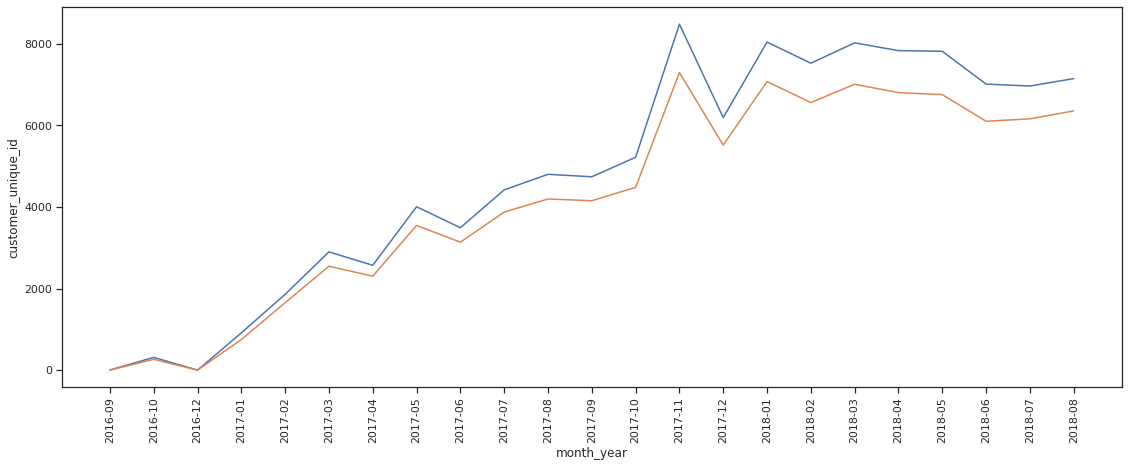

In [95]:
#Посмотрим на распределение количества пользователей и заказов в разрезе месяца
df_users_by_month = df_items.groupby('month_year', as_index=False).agg({'customer_unique_id':'count', 'order_id':'nunique'})

plt.xticks(np.arange(len(df_users_by_month)), df_users_by_month['month_year'], rotation=90)
sns.lineplot(x='month_year', y ='customer_unique_id', data=df_users_by_month)
sns.lineplot(x='month_year', y ='order_id', data=df_users_by_month)

In [96]:
#наблюдаем активный рост числа пользователей с сентября 2017 года и 
#затем выход на плато до августа 2018 года, этот период и рассмотрим 
df_orders_rfm = df_items.query('month_year > "2017-08" and month_year < "2018-09"')  \
                    .groupby(['order_id', 'order_delivered_customer_date', 'customer_unique_id'], as_index=False)  \
                    .agg({'price': 'sum'})
df_orders_rfm.head()

,order_id,order_delivered_customer_date,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,871766c5855e863f6eccc05f988b23cb,58.90
1,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,3818d81c6709e39d06b2738a8d3a2474,199.00
2,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,af861d436cfc08b2c2ddefd0ba074622,12.99
3,00054e8431b9d7675808bcb819fb4a32,2017-12-18 22:03:38,635d9ac1680f03288e72ada3a1035803,19.90
4,000576fe39319847cbb9d288c5617fa6,2018-07-09 14:04:07,fda4476abb6307ab3c415b7e6d026526,810.00


**Для расчета R (времени с последней покупки) нам нужна текущая дата. Смоделируем проведение RFM-анализа на дату сразу после окончания периода**
Добавим столбец с количеством дней между покупкой и NOW. Далее чтобы найти значения R - нужно будет найти минимум этого
столбца для каждого клиента.
И затем сформируем R,F,M

In [97]:
NOW = df_orders_rfm['order_delivered_customer_date'].max() + datetime.timedelta(days=1)
NOW

Timestamp('2018-10-18 13:22:46')

In [98]:
df_orders_rfm['days_after_last_order'] = df_orders_rfm['order_delivered_customer_date'].apply(lambda x: (NOW - x).days)

In [99]:
rfm = df_orders_rfm.groupby('customer_unique_id', as_index=False)  \
            .agg({'days_after_last_order':'min',  \
                  'order_delivered_customer_date': 'count',  \
                 'price':'sum'})
rfm.rename(columns={'days_after_last_order': 'Recency', 'order_delivered_customer_date': 'Frequency', 'price':'Monetary'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,324,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,193,1,154.00


**Чтобы вывести ранги для данных - необходимо разбить данные на диапазоны. Используем перцентили, отсекающие по 20%
пользователей**

In [100]:
level=[0.2, 0.4, 0.6, 0.8]
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile(level).to_dict()
quantiles

{'Recency': {0.2: 111.0, 0.4: 175.0, 0.6: 237.0, 0.8: 307.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.97999999999999, 0.8: 179.7}}

In [101]:
# Далее присвоим ранги для Recency (меньшее значение недавности покупки - лучше)

intervals_R=[0]
for i in range(len(quantiles['Recency'])): 
    intervals_R.append(quantiles['Recency'][level[i]])
intervals_R.append(rfm.Recency.max())
rfm['R']=pd.cut(rfm.Recency, intervals_R, labels=['5', '4', '3', '2', '1'])

In [102]:
# % пользователей с одной покупкой
rfm.loc[rfm.Frequency==1].Frequency.count() / rfm.Frequency.count() *100

97.51661129568106

Возникает ситуация, что для Frequency перцентили не подходят т.к преобладающее кол-во пользователей совершили 1 покупку. Данных о продукте мы не имеем, либо у нас дорогой премиум товар, который редко покупают повторно, либо что-то не так с сервисом.

Метрика Frequency находится в диапазоне от 1 до 11. Примем во внимание большой объем наблюдений и ранжируем следующим образом:

-  [1-3] покупки ранг 1
-  (3-5] покупок ранг 2
-  (5-7] покупок ранг 3
-  (7-9] покупок ранг 4
-  (9-11] покупок ранг 5

In [103]:
# Присвоим ранги для Frequency 
intervals_F=[0, 3, 5, 7, 9, 12]
rfm['F']=pd.cut(rfm.Frequency, intervals_F, labels=['1', '2', '3', '4', '5'])

In [104]:
# Присвоим ранги для Monetary (чем больше сумма покупок, тем лучше)
intervals_M=[0]
for i in range(len(quantiles['Monetary'])): 
    intervals_M.append(quantiles['Monetary'][level[i]])
intervals_M.append(rfm.Monetary.max())
rfm['M']=pd.cut(rfm.Monetary, intervals_M, labels=['1','2','3','4','5'])

rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,4,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,324,1,180.00,1,1,5
4,0004bd2a26a76fe21f786e4fbd80607f,193,1,154.00,3,1,4


In [105]:
# скомбинируем значения R, F, M
rfm=rfm.astype({'R':'string', 'F':'string', 'M':'string'})
rfm['RFM_score'] = rfm['R'] + rfm['F'] + rfm['M']
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,4,1,1,411
2,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,324,1,180.00,1,1,5,115
4,0004bd2a26a76fe21f786e4fbd80607f,193,1,154.00,3,1,4,314


In [106]:
# При трех метриках и 5-бальной ранговой системе вариантов комбинаций будет 125. С таким кол-вом комбинаций, конечно, работать
# не удобно. Разобъем пользователей по сегментам, в зависимости от RFM_score. 

# Создадим столбец с рангами, чтобы затем заменить его на названия сегментов
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

# В словарь, с помощью регулярных выражений, занесем правила, по которым будем делить пользователей на сегменты. Как писалось
# выше, сложно оценить по кол-ву покупок к какому сегменту отнести покупателя, не зная что за товар продается. Поэтому в каждый
# сегмент попали покупатели с одной покупкой (т.к. они составляют основную массу покупателей), в некоторых сегментах это ранги
# 1-2, в некоторых 1-5. Сегментирование происходит скорее по метрикам Recency и Monetary. 

segment_map = {
    r'[1-2][1-2][1-2]': 'бездействующие', # покупали давно, мало заказов, маленькая выручка 
    r'[1-2][1-2][3-4]': 'в зоне риска', # покупали давно, мало заказов, средняя выручка 
    r'[1-2][1-5]5': 'не можем потерять', # покупали давно, не мало заказов, высокая выручка 
    r'3[1-2][1-2]': 'спящие', # покупали относительно недавно, мало заказов, маленькая выручка 
    r'3[1-2]3': 'требуют внимание', # покупали относительно недавно, мало заказов, средняя выручка 
    r'[3-4][1-5][4-5]': 'лояльные пользователи', # покупали относительно недавно, не мало заказов, высокая выручка 
    r'4[1-5]1': 'многообещающие', # покупали недавно, не мало заказов, маленькая выручка 
    r'5[1-5]1': 'новые пользователи', # покупали недавно, не мало заказов, маленькая выручка 
    r'[4-5][1-5][2-3]': 'потенциально-лояльные', # покупали недавно, не мало заказов, средняя выручка 
    r'5[1-5][4-5]': 'чемпионы'} # покупали недавно, не мало заказов, высокая выручка 

In [107]:
# заменим ранги на названия сегментов
rfm['Segment'] = rfm['Segment'].replace(segment_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,4,1,4,414,лояльные пользователи
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,4,1,1,411,многообещающие
2,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,1,1,1,111,бездействующие
3,0004aac84e0df4da2b147fca70cf8255,324,1,180.00,1,1,5,115,не можем потерять
4,0004bd2a26a76fe21f786e4fbd80607f,193,1,154.00,3,1,4,314,лояльные пользователи


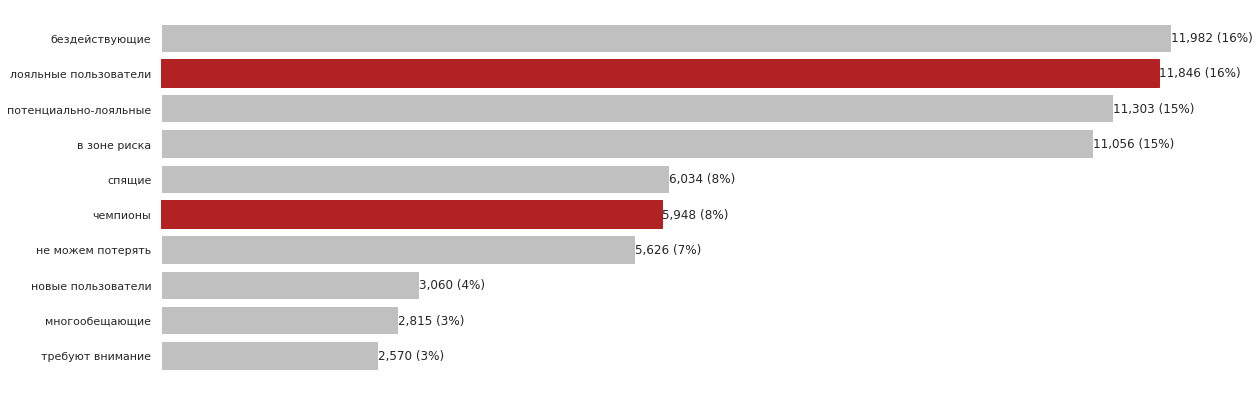

In [108]:
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['чемпионы', 'лояльные пользователи']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [109]:
# Для вывода описания границ интервалов для метрик определим функцию

def description(score):
    r = int(score[0])
    f = int(score[1])
    m = int(score[2])
    rstr = "от " + str(intervals_R[r-1]) + " до " + str(intervals_R[r]) + " дней с даты последней покупки "
    fstr = "от " + str(intervals_F[f-1]) + " до " + str(intervals_F[f]) + " покупок в год "
    mstr = "от " + str(round(intervals_M[m-1], 2)) + " до " + str(round(intervals_M[m], 2)) + " руб. в год "
    return ("Границы метрик R: " + rstr + " F: "+ fstr+ " M: "+ mstr)

# создадим столбец с описанием
rfm['description_intervals'] = rfm['RFM_score'].apply(description) 
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_score,Segment,description_intervals
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,4,1,4,414,лояльные пользователи,Границы метрик R: от 237.0 до 307.0 дней с дат...
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,4,1,1,411,многообещающие,Границы метрик R: от 237.0 до 307.0 дней с дат...
2,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,1,1,1,111,бездействующие,Границы метрик R: от 0 до 111.0 дней с даты по...
3,0004aac84e0df4da2b147fca70cf8255,324,1,180.00,1,1,5,115,не можем потерять,Границы метрик R: от 0 до 111.0 дней с даты по...
4,0004bd2a26a76fe21f786e4fbd80607f,193,1,154.00,3,1,4,314,лояльные пользователи,Границы метрик R: от 175.0 до 237.0 дней с дат...


In [110]:
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

# Описание границ метрик, по которым сотрудники по работе с покупателями смогут:
#     а) понять к какому сегменту относится пользователь
#     б) настроить работу с пользователями, в зависимости от сегмента
    
rfm.groupby(['RFM_score', 'Segment', 'description_intervals'], as_index=False)  \
    .agg({'customer_unique_id':'count'})  \
    .rename(columns={'customer_unique_id': 'cnt_customers'})

,RFM_score,Segment,description_intervals,cnt_customers
0,111,бездействующие,Границы метрик R: от 0 до 111.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 0 до 39.9 руб. в год,2920
1,112,бездействующие,Границы метрик R: от 0 до 111.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 39.9 до 69.9 руб. в год,3187
2,113,в зоне риска,Границы метрик R: от 0 до 111.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 69.9 до 109.98 руб. в год,2774
3,114,в зоне риска,Границы метрик R: от 0 до 111.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 109.98 до 179.7 руб. в год,2677
4,115,не можем потерять,Границы метрик R: от 0 до 111.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 179.7 до 13440.0 руб. в год,2886
5,125,не можем потерять,Границы метрик R: от 0 до 111.0 дней с даты последней покупки F: от 3 до 5 покупок в год M: от 179.7 до 13440.0 руб. в год,1
6,211,бездействующие,Границы метрик R: от 111.0 до 175.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 0 до 39.9 руб. в год,2951
7,212,бездействующие,Границы метрик R: от 111.0 до 175.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 39.9 до 69.9 руб. в год,2924
8,213,в зоне риска,Границы метрик R: от 111.0 до 175.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 69.9 до 109.98 руб. в год,2806
9,214,в зоне риска,Границы метрик R: от 111.0 до 175.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 109.98 до 179.7 руб. в год,2799
